# Вчитување на податоците и потребни библиотеки

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import missingno as msno

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [4]:
housing_flats = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TimskiProekt/housing_flats_1.csv")
housing_flats.head()

,Unnamed: 0,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,Лифт,Годинанаградба,Бројнабалкони,Бројнабањи,Подрум,Бројнапаркинг/гаража,Ориентација,Адреса,Годинанареновирање
0,0,127000€,41.998834,21.395788,4.0,89m²,Централно,9кат,ВоЗграда,Нов,Наместен,Да,2016.0,1Балкон,2,Да,Гаража+2Паркингместа,Североисток,UlPraska,NaN
1,1,95000€,42.009423,20.971549,6.0,135m²,Друго,4кат,ВоЗграда,Реновиран,Наместен,Не,NaN,1Тераса,2,Не,1Гаража,Југ,Centar,NaN
2,2,67500€,41.987070,21.451929,2.0,45m²,Централно,6кат,ВоЗграда,Нов,Полунаместен,Да,2021.0,Тераса+1Балкон,1,Не,1Паркинг,Исток,NaN,NaN
3,3,95000€,41.987628,21.447906,3.0,99m²,Струја,Приземје,ВоЗграда,Реновиран,Празен,Да,NaN,2Балкони,1,Да,1Паркинг,Исток,AnastasMitrev23,NaN
4,4,52000€,42.060063,21.450033,3.0,83m²,Струја,3кат,ВоЗграда,Реновиран,Наместен,Не,1985.0,1Балкон,2,Да,Нема,Југоисток,УлицаРадишанска,2010.0


# Препроцесирање на податоците за станови

In [5]:
housing_flats.shape

(11187, 20)

In [6]:
housing_flats.dtypes

Unnamed: 0                int64
Цена                     object
Латитуда                float64
Лонгитуда               float64
Бројнасоби              float64
Квадратура               object
Греење                   object
Спрат                    object
Типнастанот              object
Состојба                 object
Опрема                   object
Лифт                     object
Годинанаградба          float64
Бројнабалкони            object
Бројнабањи               object
Подрум                   object
Бројнапаркинг/гаража     object
Ориентација              object
Адреса                   object
Годинанареновирање      float64
dtype: object

Имаме 11187 инстанци од станови, а за секој стан првично имаме по 19 атрибути вклучувајќи ја цената на станот и занемарувајќи ја колоната Unnamed која претставува само индекс на инстанците. На атрибутите од тип object, понатаму ќе треба да се направи енкодирање, бидејќи поголемиот дел од моделите не подржуваат категориски вредности.

## Справување со вредности кои недостасуваат

In [7]:
missing_values_flats = housing_flats.isnull().sum()
percentage = 100 * housing_flats.isnull().sum() / len(housing_flats)
missing_values_flats_table = pd.concat([missing_values_flats, percentage], axis=1)
missing_values_flats_table.columns = ['Num. of missing values','% of missing values']
missing_values_flats_table

,Num. of missing values,% of missing values
Unnamed: 0,0,0.000000
Цена,0,0.000000
Латитуда,0,0.000000
Лонгитуда,0,0.000000
Бројнасоби,14,0.125145
Квадратура,64,0.572093
Греење,14,0.125145
Спрат,1,0.008939
Типнастанот,87,0.777688
Состојба,87,0.777688


Во врска со нулл вредностите може да забелижиме дека 7 атрибути имаат исти број на нулл вредности, што укажува на некаква зависност меѓу недостигањето на вредности. Тоа ќе го испитаме понатаму.

Исто така, може да видиме дека имаме голем број вредности што недостасуваат кај атрибутите: Година на градба, Адреса, Година на реновирање. Колоната Адреса може да ја дропнеме бидејќи веќе ја имаме локацијата на станот преку латитудата и лонгитудата. За атрибутот Година на градба, недостасуваат околу 56%, а за Година на реновирање недостасуваат околу 80% од податоците, со што најдобро би било да ги изоставиме и двата атрибута, или доколку фалат вредностите најизменично да се спојат во еден атрибут, но тоа ќе го испитаму понатаму.

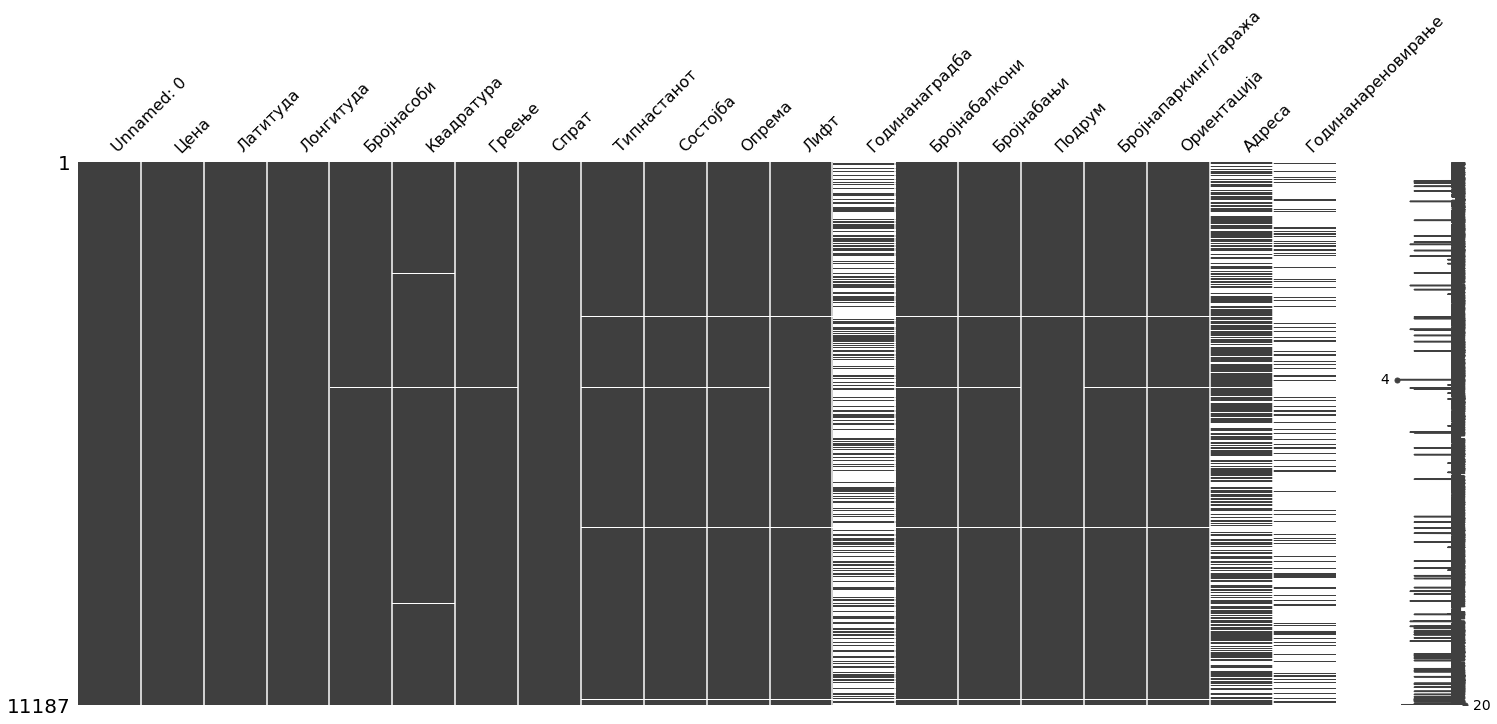

In [8]:
msno.matrix(housing_flats) 

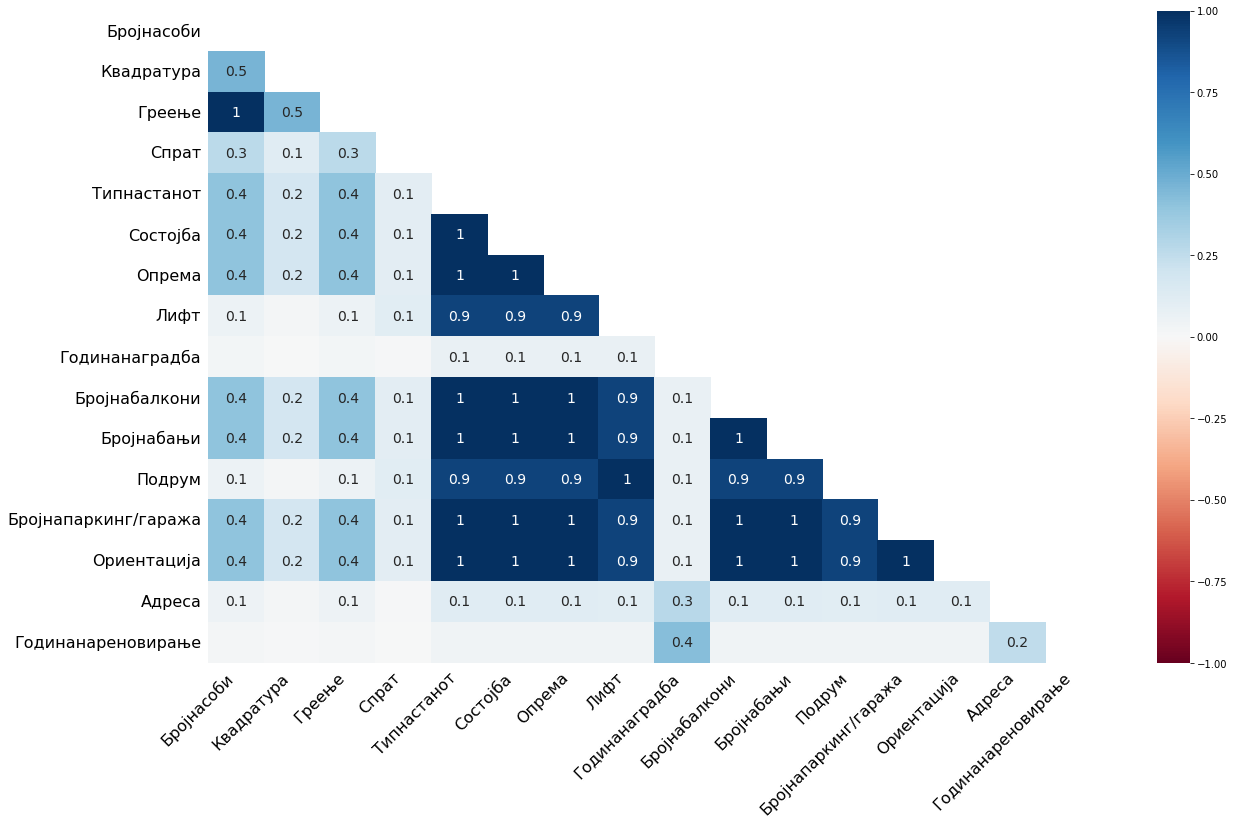

In [9]:
msno.heatmap(housing_flats)

Ќе направиме нова визуализација за атрибутите кои имаат силна корелација за вредностите кои што недостасуваат.

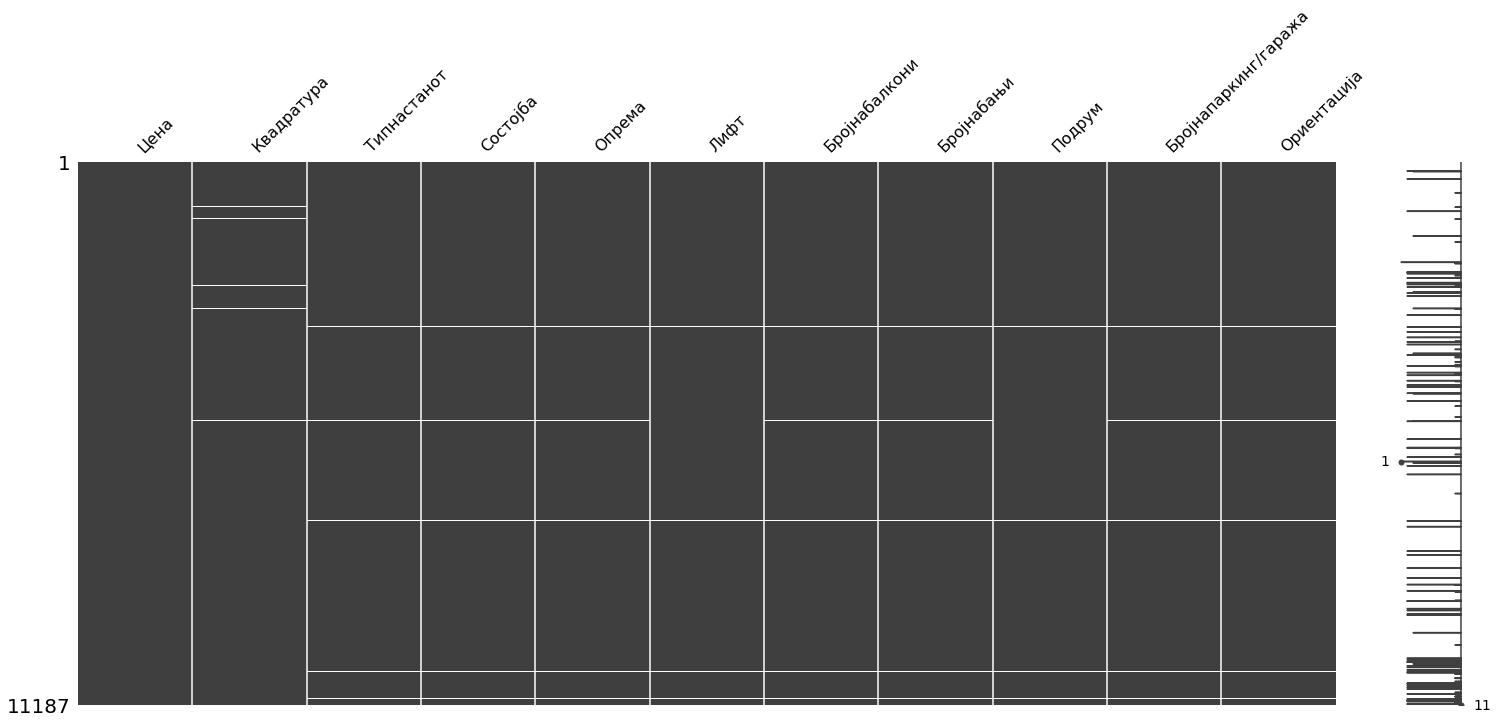

In [10]:
msno.matrix(housing_flats[['Цена', 'Квадратура', 'Типнастанот','Состојба','Опрема', 'Лифт', 'Бројнабалкони', 'Бројнабањи', 'Подрум', 'Бројнапаркинг/гаража', 'Ориентација']].sort_values('Цена'))

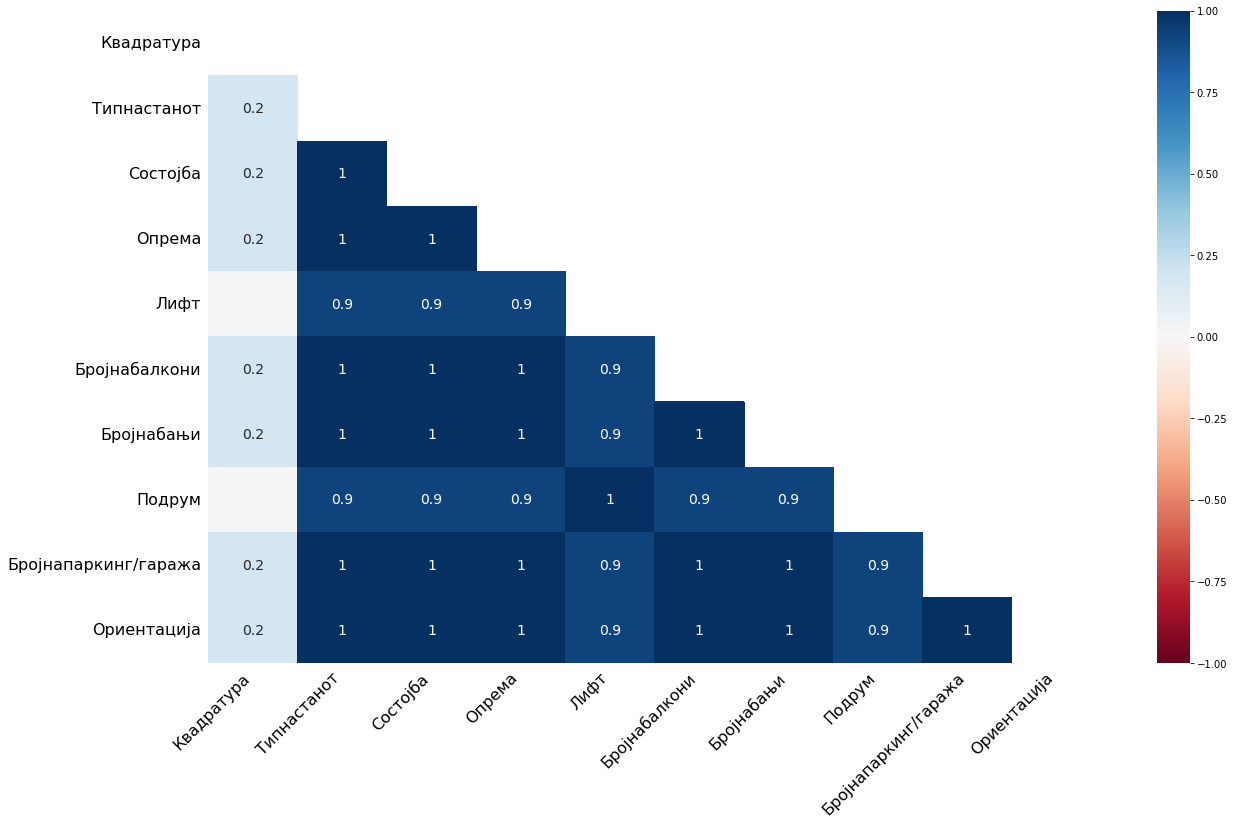

In [11]:
msno.heatmap(housing_flats[['Цена', 'Квадратура', 'Типнастанот','Состојба','Опрема', 'Лифт', 'Бројнабалкони', 'Бројнабањи', 'Подрум', 'Бројнапаркинг/гаража', 'Ориентација']])

Од ова може да зебележиме дека постои поврзаност меѓу вредностите, освен за атрибутот Квадратура. Претпоставуам дека дел од луѓето кои ги внесувале огласите,одлучиле дека нема да ги попунуваат овие полињата воопшто, и наместо тоа ќе дадат дополнително објаснување во коментар или слично.

Најдобро би било овие 87 вредности кои недостасуваат, да ги дропнеме бидејќи тоа не претставува ни 1% од целовкупното податочно множество. Исто така подобро би било да ги изоставиме и атрибутите Годинанаградба и Годинанареновирање, поради големиот процент на вредности кои недостасуваат.

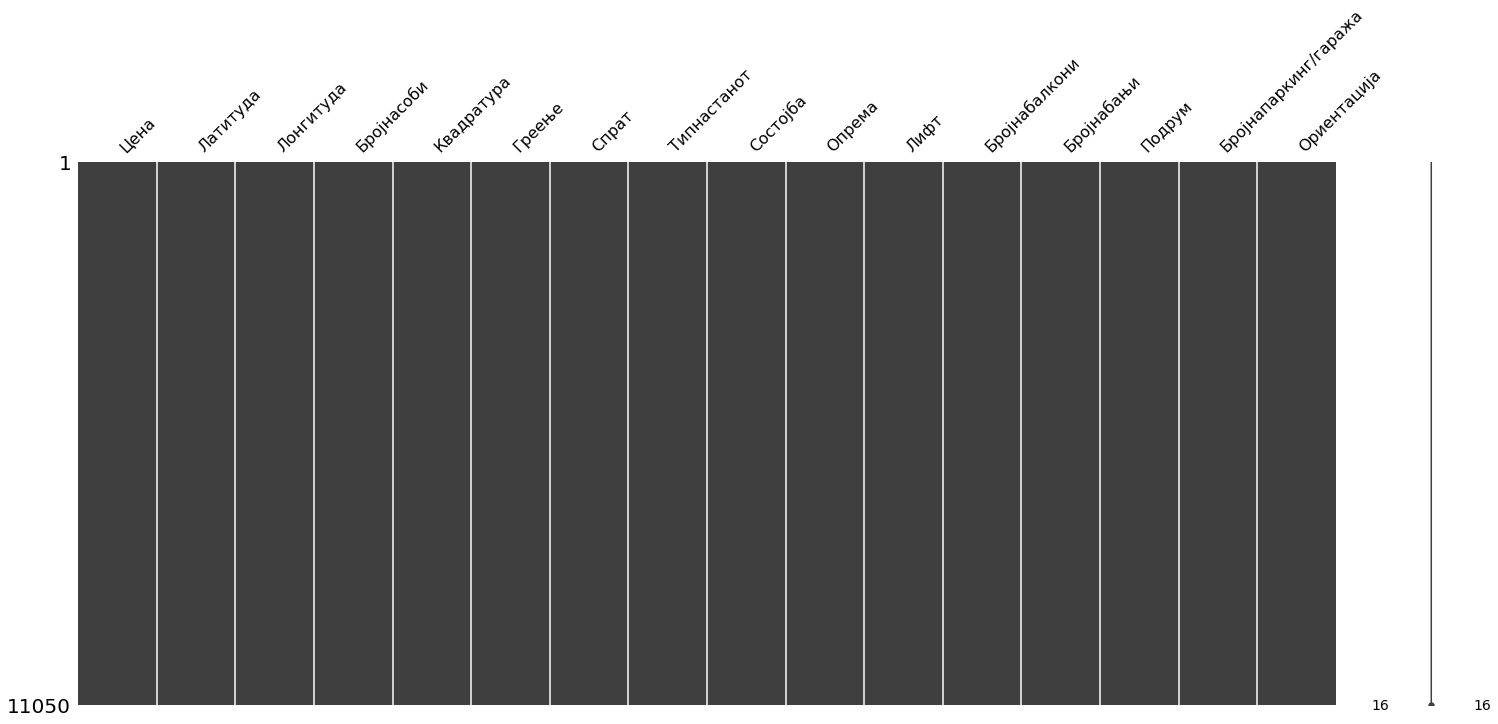

In [12]:
flats = housing_flats.copy(deep=True)
flats.drop('Unnamed: 0', inplace=True, axis=1)
flats.drop('Адреса', inplace=True, axis=1)
flats.drop('Годинанаградба', inplace=True, axis=1)
flats.drop('Годинанареновирање', inplace=True, axis=1)
flats.dropna(subset=['Ориентација'],how='all',inplace=True)
flats.dropna(subset=['Квадратура'],how='all',inplace=True)
flats = flats.reset_index(drop=True)
msno.matrix(flats) 

In [13]:
missing_values_flats2 = flats.isnull().sum()
percentage = 100 * flats.isnull().sum() / len(flats)
missing_values_flats_table2 = pd.concat([missing_values_flats2, percentage], axis=1)
missing_values_flats_table2.columns = ['Num. of missing values','% of missing values']
missing_values_flats_table2

,Num. of missing values,% of missing values
Цена,0,0.0
Латитуда,0,0.0
Лонгитуда,0,0.0
Бројнасоби,0,0.0
Квадратура,0,0.0
Греење,0,0.0
Спрат,0,0.0
Типнастанот,0,0.0
Состојба,0,0.0
Опрема,0,0.0


In [14]:
print("The shape of the data before dropping the null values:", housing_flats.shape)
print("The shape of the data after dropping the null values:", flats.shape)

The shape of the data before dropping the null values: (11187, 20)
The shape of the data after dropping the null values: (11050, 16)


Добивме податоци со 137 инстанци помалку и со 3 атрибути помалку, што повторно имаме доволно податоци за да изградиме соодветни модели.

## Отстранување на екстремни вредности

### Квадратура

In [15]:
len(flats[flats.Квадратура.str.contains('m²') == True])

11050

Сите податоци за квадратурата се изразени во метри квадратни, што значи дека само ќе треба да ја отстраниме m² од вредноста и да добиеме int64.

In [16]:
flats['Квадратура'] = flats['Квадратура'].str.split("m²", n=1, expand = True)[0] 
flats['Квадратура']= flats['Квадратура'].astype('int64') 

In [17]:
flats['Квадратура'].describe()

count     11050.000000
mean        137.078190
std        4214.245396
min           1.000000
25%          53.000000
50%          67.000000
75%          84.000000
max      405060.000000
Name: Квадратура, dtype: float64

Може да забележиме дека за вредностите на квадратурата ќе имаме многу екстремни вредности, бидејќи имаме огромно отстапување помеѓу третиот квартил и максимумот, а исто така и инстанците кои содржат вредност 1, треба да се провери дали и цената соодветствува на цена на квадрат или само е лошо внесена вредноста.

In [18]:
len(flats[flats['Квадратура'] > 250])

38

In [19]:
flats[flats['Квадратура'] >250]

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,Лифт,Бројнабалкони,Бројнабањи,Подрум,Бројнапаркинг/гаража,Ориентација
1380,480000€,41.987070,21.451929,6.0,299,Струја,1кат,ВоЗграда,Нов,Празен,Не,Тераса+Повеќеод3балкони,Повеќеод2,Да,Повеќеод3паркингместа,Југоисток
2206,470000€,41.111733,20.798579,3.0,1500,Нема,1кат,ВоЗграда,Нов,Празен,Не,2Балкони,1,Да,Гаража+Повеќеод3паркингместа,Југоисток
2331,2€,41.865485,21.940845,6.0,480,Струја,4кат,ВоЗграда,Нов,Наместен,Да,Тераса+1Балкон,Повеќеод2,Да,Гаража+1Паркинг,Североисток
2379,1€,41.987070,21.451929,6.0,1100,Друго,Приземје,ВоЗграда,Воградба,Празен,Да,Повеќеод3балкони,Повеќеод2,Да,Гаража+Повеќеод3паркингместа,Североисток
2852,600000€,41.031728,21.329358,6.0,540,Струја,3кат,Вокуќа,Нов,Наместен,Не,Тераса+Повеќеод3балкони,Повеќеод2,Не,Гаража+Повеќеод3паркингместа,Југоисток
3177,1€,41.987070,21.451929,1.0,405060,Нема,1кат,ВоЗграда,Стар,Празен,Да,1Балкон,1,Не,1Паркинг,Југ
3213,200€,41.987070,21.451929,2.0,525,Централно,Поткровје,ВоЗграда,Нов,Наместен,Да,2Балкони,1,Да,1Паркинг,Исток
3234,1€,41.987070,21.451929,4.0,280,Друго,1кат,ВоЗграда,Воградба,Празен,Да,1Тераса,Повеќеод2,Да,2Паркингместа,Северозапад
3408,1€,41.991502,21.397810,6.0,803,Струја,4кат,ВоЗграда,Нов,Празен,Не,Повеќеод3балкони,Повеќеод2,Да,Повеќеод3паркингместа,Исток
4183,41500€,42.008532,20.967783,3.0,653,Струја,11кат,ВоЗграда,Реновиран,Наместен,Да,1Балкон,1,Да,2Паркингместа,Исток


Од овие инстанци може да забележиме дека квадратите на станот, бројот на собите со и цените логички не одговараат едни на други, па затоа сметам дека овие вредности не се добро пополнети, со што најдобро би било да се отстранат овие инстанци од множеството.

In [20]:
len(flats[flats['Квадратура'] < 20])

47

In [21]:
flats[flats['Квадратура'] < 20]

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,Лифт,Бројнабалкони,Бројнабањи,Подрум,Бројнапаркинг/гаража,Ориентација
235,1€,41.978187,21.427388,2.0,1,Централно,3кат,ВоЗграда,Нов,Празен,Да,1Тераса,1,Да,1Паркинг,Југ
263,1€,41.978187,21.427388,25.0,1,Централно,1кат,ВоЗграда,Нов,Празен,Да,1Балкон,2,Не,Нема,Југ
625,36500€,41.111733,20.798579,1.0,17,Нема,Приземје,ВоЗграда,Реновиран,Празен,Да,1Балкон,1,Не,1Паркинг,Исток
688,84000€,41.987070,21.451929,3.0,3,Централно,4кат,ВоЗграда,Стар,Празен,Не,1Тераса,2,Не,1Паркинг,Југ
711,1€,41.978187,21.427388,25.0,1,Нема,1кат,ВоЗграда,Реновиран,Празен,Да,1Балкон,2,Не,1Паркинг,Југ
716,1€,41.987070,21.451929,25.0,1,Централно,1кат,ВоЗграда,Реновиран,Празен,Да,1Балкон,1,Да,Нема,Југ
718,1€,41.991502,21.397810,25.0,1,Централно,1кат,ВоЗграда,Реновиран,Празен,Да,1Балкон,2,Да,Нема,Југ
801,1€,41.949632,21.502494,25.0,1,Централно,1кат,ВоЗграда,Реновиран,Празен,Да,1Балкон,2,Да,Нема,Југ
802,1€,42.013646,21.325860,25.0,1,Нема,1кат,ВоЗграда,Реновиран,Празен,Не,1Балкон,1,Да,Нема,Југ
803,1€,41.987070,21.451929,35.0,1,Централно,1кат,ВоЗграда,Реновиран,Празен,Да,1Балкон,2,Да,1Паркинг,Југ


Овде поголемиот дел од вреднотите, имаат или превисоки цени за толку малку квадрати, или преголем број на соби. Но нема да ги остранам овие вредности, бидејќи има и инстанци кои имаат логика со цена и број на соби според квадратите. Овие нелогичности дополнително ќе се исфилтрираат, со цената и бројот на соби. Само ќе ги отстранам оние кои имаат квадратура 1.

In [22]:
print("Димензии на податоците пред да ги остраниме преголемата сума на квадратурата: " + str(flats.shape))
flats.drop(flats[flats['Квадратура'] == 1].index, inplace = True)
flats.drop(flats[flats['Квадратура'] > 250].index, inplace = True)
print("Димензии на податоците пo отстранувањето на екстремните вредности: " + str(flats.shape))

Димензии на податоците пред да ги остраниме преголемата сума на квадратурата: (11050, 16)
Димензии на податоците пo отстранувањето на екстремните вредности: (10981, 16)


In [23]:
flats = flats.reset_index(drop=True)

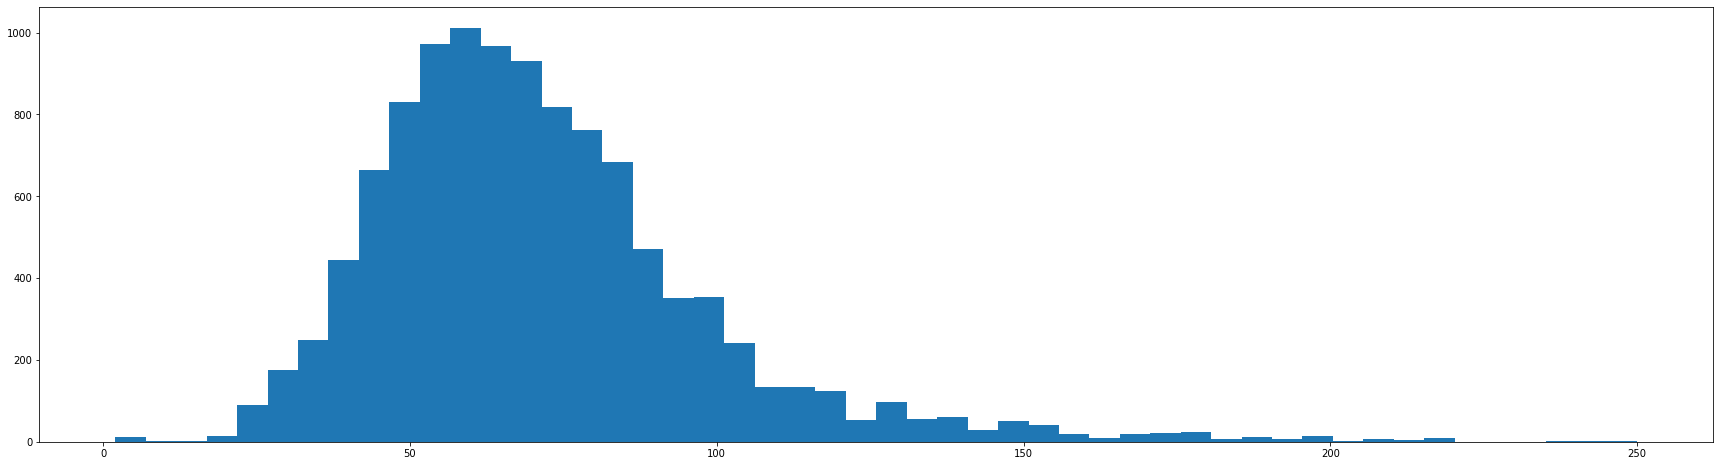

In [24]:
plt.figure(figsize=(30,8))
plt.hist(flats['Квадратура'], bins=50)
plt.ticklabel_format(style='plain')
plt.show() 

### Број на соби

In [25]:
flats['Бројнасоби'].describe()

count    10981.000000
mean         6.579000
std          9.727661
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         45.000000
Name: Бројнасоби, dtype: float64

И за овој атрибут имаме екстремни вредности, поради големата разлика помеѓу третиот квартил и максималната вредност.

In [26]:
len(flats[flats['Бројнасоби'] > 10])

1549

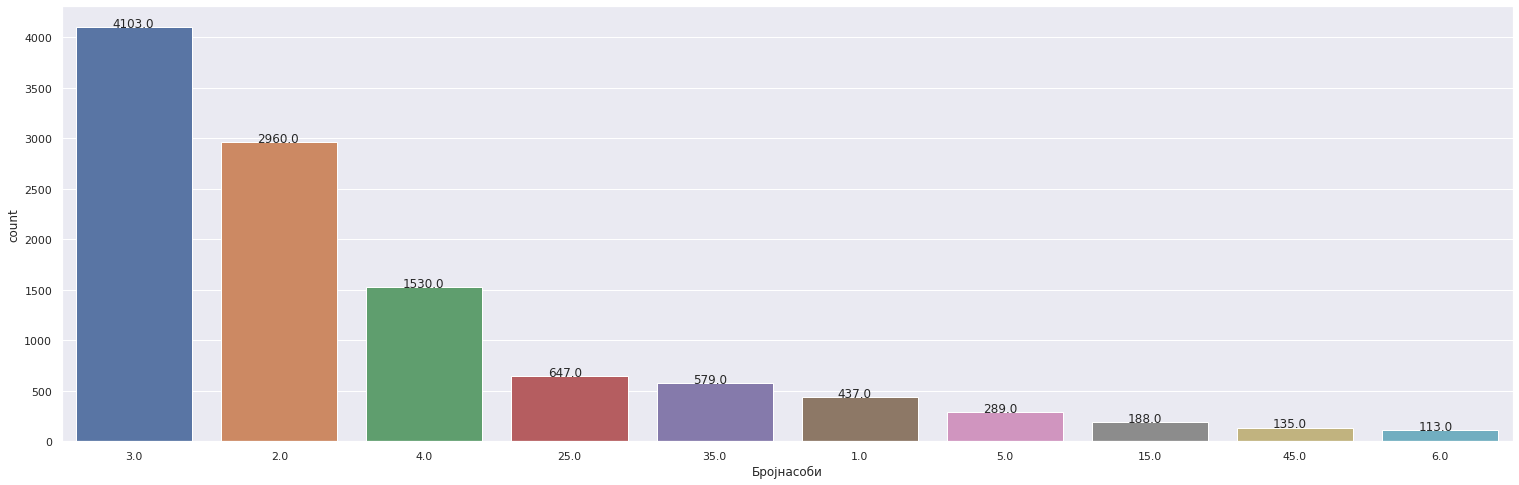

In [27]:
sns.set(rc={'figure.figsize':(26,8)})
ax = sns.countplot(x=flats['Бројнасоби'],
                   order=flats['Бројнасоби'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

Бидејќи не се малку податоци, вредностите 15, 25, 35, 45 ќе треба да се заменат со број на соби соодветен на квадратурата на станот.

In [28]:
nor_sobi = flats[flats['Бројнасоби'] < 10]

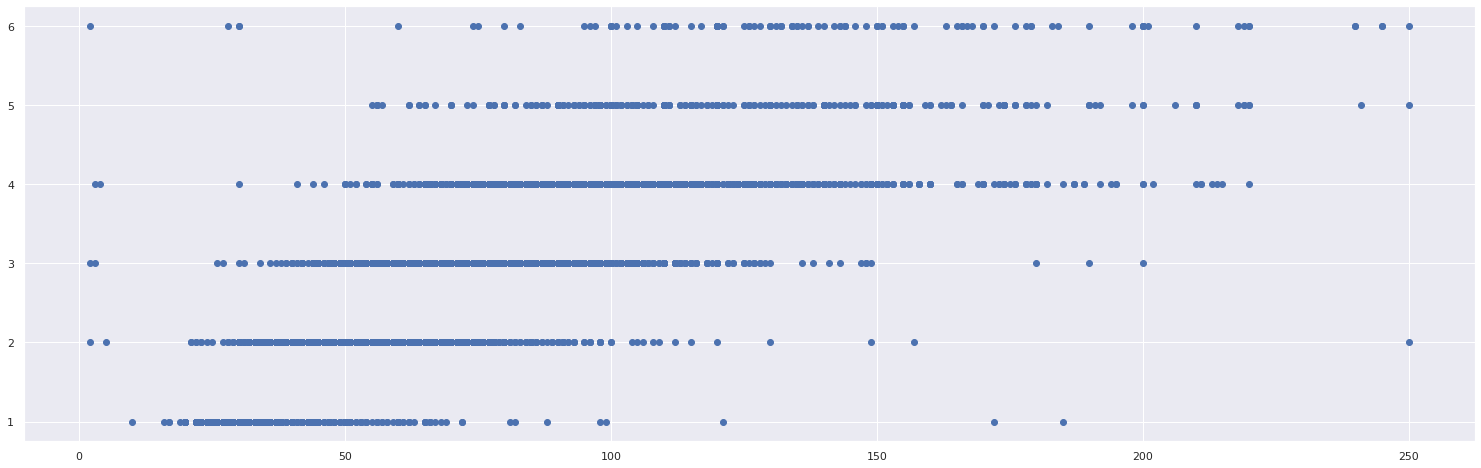

In [29]:
plt.scatter(nor_sobi['Квадратура'], nor_sobi['Бројнасоби'])

За податоците кои имаат голем број соби, ќе ги заменам на слледниот начин: од 10м2 до 40м2 има една соба, од 40м2 до 60м2 две соби, од 60м2 до 100м2 три соби, од 100м2 до 130м2 4 соби, до 150м2 5 соби, се над 150м2 има 6 соби.

In [30]:
pom_flats = flats[flats['Бројнасоби'] > 10]
pom_flats.shape

(1549, 16)

In [31]:
pom_flats['Бројнасоби'] = np.where(pom_flats.Квадратура < 40, 1 , pom_flats.Бројнасоби)
pom_flats['Бројнасоби'] = np.where(((pom_flats.Квадратура >= 40) & (pom_flats.Квадратура < 60)), 2 , pom_flats.Бројнасоби)
pom_flats['Бројнасоби'] = np.where(((pom_flats.Квадратура >= 60) & (pom_flats.Квадратура < 100)), 3 , pom_flats.Бројнасоби)
pom_flats['Бројнасоби'] = np.where(((pom_flats.Квадратура >= 100) & (pom_flats.Квадратура < 130)), 4 , pom_flats.Бројнасоби)
pom_flats['Бројнасоби'] = np.where(((pom_flats.Квадратура >= 130) & (pom_flats.Квадратура < 150)), 5 , pom_flats.Бројнасоби)
pom_flats['Бројнасоби'] = np.where(pom_flats.Квадратура >= 150, 6 , pom_flats.Бројнасоби)

In [32]:
len(flats) == len(pom_flats) + len(nor_sobi)

True

In [33]:
flats = nor_sobi.append(pom_flats, ignore_index=True)

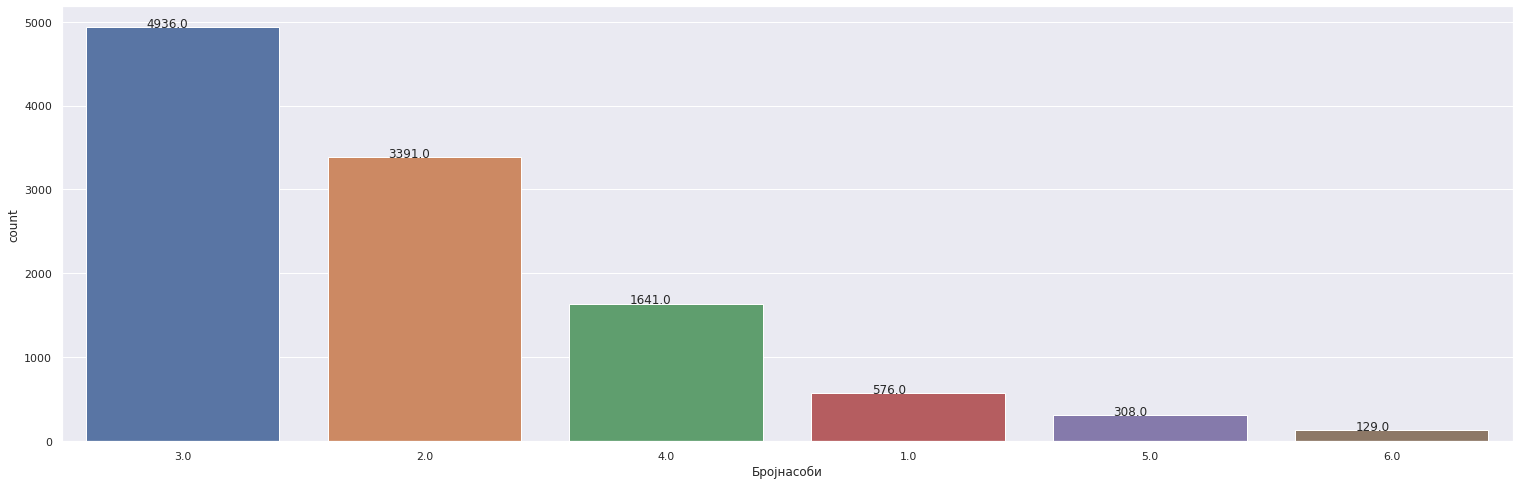

In [34]:
sns.set(rc={'figure.figsize':(26,8)})
ax = sns.countplot(x=flats['Бројнасоби'],
                   order=flats['Бројнасоби'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

Можеме да забележиме дека не направивме изместување на податоците, односно повторно најголем број од становите имаат по 3 соби,  па по 2 соби, па 4, 1, 5 и најмалку станови има со по 6 соби.

### Цена

**Претворање на цените во int64 и во една валута.**

In [35]:
flats_cena_dogovor = pd.DataFrame(columns=flats.columns)
flats_cena_dogovor = flats[flats.Цена.isin(['По договор']) == True]
print("Податочното множество има", len(flats_cena_dogovor), "инстанци на атрибутот Цена: По договор")

Податочното множество има 974 инстанци на атрибутот Цена: По договор


Овие инстанци, бидејќи не соджат конкретна цена ќе ги сместам во друго множество на податоци, кои ќе ги искористиме за тестирање на моделите.

In [36]:
#flats_cena_mkd = pd.DataFrame(columns=flats.columns)
flats_cena_mkd = flats[flats.Цена.str.contains('МКД') == True]
print("Податочното множество има", len(flats_cena_mkd), "инстанци со вредност на атрибутот Цена изразена во денари")

Податочното множество има 160 инстанци со вредност на атрибутот Цена изразена во денари


In [37]:
flats_cena_mkd['Цена'] = flats_cena_mkd['Цена'].str.split("МКД", n=1, expand = True)[0]
flats_cena_mkd['Цена'] = flats_cena_mkd['Цена'].astype('int64')
flats_cena_mkd.head()

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,Лифт,Бројнабалкони,Бројнабањи,Подрум,Бројнапаркинг/гаража,Ориентација
49,1,41.090247,21.016781,2.0,70,Дрва,4кат,ВоЗграда,Реновиран,Наместен,Не,1Балкон,1,Да,Нема,Запад
115,1,41.111733,20.798579,2.0,52,Струја,Приземје,ВоЗграда,Стар,Празен,Не,1Тераса,1,Не,1Паркинг,Југ
126,95800,42.000963,21.416083,3.0,71,Централно,Поткровје,ВоЗграда,Стар,Полунаместен,Не,1Балкон,1,Да,Нема,Југоисток
289,1,41.031728,21.329358,6.0,100,Друго,1кат,ВоЗграда,Нов,Наместен,Не,2Балкони,2,Да,1Паркинг,Југозапад
368,9000,41.031728,21.329358,2.0,40,Струја,1кат,ВоЗграда,Реновиран,Наместен,Не,1Балкон,1,Да,1Паркинг,Југоисток


In [38]:
flats_cena_euro = pd.DataFrame(columns=flats.columns)
flats_cena_euro = flats[flats.Цена.str.contains('€') == True]
print("Податочното множество има", len(flats_cena_euro), "инстанци со вредност на атрибутот Цена изразена во евра")

Податочното множество има 9847 инстанци со вредност на атрибутот Цена изразена во евра


In [39]:
flats_cena_euro['Цена'] = flats_cena_euro['Цена'].str.split("€", n=1, expand = True)[0]
flats_cena_euro['Цена']= flats_cena_euro['Цена'].astype('int64')
flats_cena_euro.head()

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,Лифт,Бројнабалкони,Бројнабањи,Подрум,Бројнапаркинг/гаража,Ориентација
0,127000,41.998834,21.395788,4.0,89,Централно,9кат,ВоЗграда,Нов,Наместен,Да,1Балкон,2,Да,Гаража+2Паркингместа,Североисток
1,95000,42.009423,20.971549,6.0,135,Друго,4кат,ВоЗграда,Реновиран,Наместен,Не,1Тераса,2,Не,1Гаража,Југ
2,67500,41.987070,21.451929,2.0,45,Централно,6кат,ВоЗграда,Нов,Полунаместен,Да,Тераса+1Балкон,1,Не,1Паркинг,Исток
3,95000,41.987628,21.447906,3.0,99,Струја,Приземје,ВоЗграда,Реновиран,Празен,Да,2Балкони,1,Да,1Паркинг,Исток
4,52000,42.060063,21.450033,3.0,83,Струја,3кат,ВоЗграда,Реновиран,Наместен,Не,1Балкон,2,Да,Нема,Југоисток


In [40]:
len(flats_cena_dogovor) + len(flats_cena_euro) + len(flats_cena_mkd) == len(flats)

True

Пред се, за да работиме со иста валута на цените, валутата денари ќе ја претворам во евра.

In [41]:
def convert_cena_to_euros(cena):
    euros = cena * 0.016275323
    return math.ceil(euros)

In [42]:
flats_cena_mkd['Цена'] = flats_cena_mkd['Цена'].apply(convert_cena_to_euros).values
flats_cena_mkd.head()

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,Лифт,Бројнабалкони,Бројнабањи,Подрум,Бројнапаркинг/гаража,Ориентација
49,1,41.090247,21.016781,2.0,70,Дрва,4кат,ВоЗграда,Реновиран,Наместен,Не,1Балкон,1,Да,Нема,Запад
115,1,41.111733,20.798579,2.0,52,Струја,Приземје,ВоЗграда,Стар,Празен,Не,1Тераса,1,Не,1Паркинг,Југ
126,1560,42.000963,21.416083,3.0,71,Централно,Поткровје,ВоЗграда,Стар,Полунаместен,Не,1Балкон,1,Да,Нема,Југоисток
289,1,41.031728,21.329358,6.0,100,Друго,1кат,ВоЗграда,Нов,Наместен,Не,2Балкони,2,Да,1Паркинг,Југозапад
368,147,41.031728,21.329358,2.0,40,Струја,1кат,ВоЗграда,Реновиран,Наместен,Не,1Балкон,1,Да,1Паркинг,Југоисток


По претварањето на валутата, ќе ги споиме податоците во едно множество, за од еднаш да ги отстраниме нелогичните цени.

In [43]:
flats_euros = flats_cena_euro.append(flats_cena_mkd, ignore_index=True)

In [44]:
flats_euros

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,Лифт,Бројнабалкони,Бројнабањи,Подрум,Бројнапаркинг/гаража,Ориентација
0,127000,41.998834,21.395788,4.0,89,Централно,9кат,ВоЗграда,Нов,Наместен,Да,1Балкон,2,Да,Гаража+2Паркингместа,Североисток
1,95000,42.009423,20.971549,6.0,135,Друго,4кат,ВоЗграда,Реновиран,Наместен,Не,1Тераса,2,Не,1Гаража,Југ
2,67500,41.987070,21.451929,2.0,45,Централно,6кат,ВоЗграда,Нов,Полунаместен,Да,Тераса+1Балкон,1,Не,1Паркинг,Исток
3,95000,41.987628,21.447906,3.0,99,Струја,Приземје,ВоЗграда,Реновиран,Празен,Да,2Балкони,1,Да,1Паркинг,Исток
4,52000,42.060063,21.450033,3.0,83,Струја,3кат,ВоЗграда,Реновиран,Наместен,Не,1Балкон,2,Да,Нема,Југоисток
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10002,7,41.111733,20.798579,1.0,30,Соларнаенергија,1кат,Вокуќа,Нов,Наместен,Не,1Балкон,1,Не,2Паркингместа,Запад
10003,1,41.999359,21.327548,2.0,51,Струја,4кат,ВоЗграда,Реновиран,Наместен,Да,3Балкони,1,Да,1Паркинг,Југ
10004,188,41.978187,21.427388,2.0,57,Струја,5кат,ВоЗграда,Нов,Празен,Да,1Балкон,1,Не,1Паркинг,Југоисток
10005,163,41.987070,21.451929,3.0,60,Централно,5кат,ВоЗграда,Реновиран,Полунаместен,Да,1Балкон,1,Да,Повеќеод3паркингместа,Југоисток


In [45]:
len(flats_euros) + len(flats_cena_dogovor) == len(flats)

True

In [46]:
flats_euros['Цена'].describe()

count    1.000700e+04
mean     1.585790e+05
std      1.004780e+07
min      1.000000e+00
25%      9.000000e+02
50%      4.250000e+04
75%      6.990000e+04
max      1.000000e+09
Name: Цена, dtype: float64

Имаме многу отстапување помеѓу минимумот и првиот квартил, но и помеѓу максимумот и третиот квартил, што значи дека имаме и овде екстремни вредности.

In [47]:
len(flats_euros[flats_euros['Цена'] == 1])

1381

Околу 12% од податоците за вредност на атриутот Цена имаа 1, што не ни се од корист за тренирањето на моделот, па истите ќе ги сместиме во множество заедно со податоците со Цена по договор.

In [48]:
(len(flats_euros[flats_euros['Цена'] < 10000]) - len(flats_euros[flats_euros['Цена'] == 1])) 

2739

Бидејќи не може стан да се продава за цена помала од оваа ниска граница од 10000 евра, сметам дека овие 25% од податоците се за станови или деловни простори кои се изнајмуваат под кирија, и цената ставена е претставува цена која се плаќа на месечно ниво. Ваквите станови и простори не ни се од интерес, па и овие податоци може да ги искористиме доколку сакаме повеќе да го истестираме моделот.

---



In [49]:
len(flats_euros[flats_euros['Цена'] > 300000])

11

In [50]:
flats_euros[flats_euros['Цена'] > 300000]

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,Лифт,Бројнабалкони,Бројнабањи,Подрум,Бројнапаркинг/гаража,Ориентација
643,999999999,42.019073,21.441879,4.0,100,Струја,2кат,ВоЗграда,Реновиран,Празен,Не,1Балкон,2,Да,1Гаража,Север
1244,71238480,41.346182,21.553379,3.0,61,Струја,Приземје,ВоЗграда,Нов,Полунаместен,Не,1Тераса,1,Не,1Паркинг,Југ
1328,330000,41.987070,21.451929,6.0,250,Централно,4кат,ВоЗграда,Воградба,Празен,Да,Тераса+Повеќеод3балкони,Повеќеод2,Да,2Паркингместа,Југ
2040,320000,42.013646,21.325860,4.0,213,Друго,Приземје,ВоЗграда,Нов,Наместен,Да,1Балкон,Повеќеод2,Да,2Паркингместа,Југоисток
2585,310000,41.991502,21.397810,6.0,240,Струја,Приземје,Вокуќа,Реновиран,Луксузен,Не,Повеќеод3балкони,Повеќеод2,Не,2Паркингместа,Југозапад
2844,570000,42.013646,21.325860,4.0,83,Струја,5кат,ВоЗграда,Стар,Празен,Не,1Тераса,1,Да,Гаража+1Паркинг,Североисток
5221,350000,41.991502,21.397810,5.0,198,Струја,2кат,ВоЗграда,Нов,Наместен,Не,1Балкон,Повеќеод2,Не,2Паркингместа,Југ
8038,8888888,41.987070,21.451929,5.0,210,Струја,5кат,ВоЗграда,Реновиран,Наместен,Не,2Балкони,2,Не,Повеќеод3паркингместа,Исток
8703,1111111,41.031728,21.329358,2.0,59,Централно,9кат,ВоЗграда,Нов,Наместен,Да,Тераса+1Балкон,1,Да,1Паркинг,Североисток
9492,70594474,41.745515,22.193960,3.0,66,Дрва,2кат,ВоЗграда,Реновиран,Полунаместен,Не,1Балкон,1,Да,Нема,Исток


Овие цени се преголеми за продавање на стан, од соодветна квадратура.

Цените кои се 'По договор' и овие нелогични цени ќе ги ставам во еден датасет, кој подоцна може да се искористи за тестирање на изградените модели.

In [51]:
flats_nelogicni_ceni = flats_euros[( (flats_euros['Цена'] <= 10000) | (flats_euros['Цена'] >= 300000) )]
flats_nelogicni_ceni.shape

(4131, 16)

In [52]:
test_flats = flats_cena_dogovor.append(flats_nelogicni_ceni, ignore_index=True)
test_flats.shape

(5105, 16)

In [53]:
flats_euros.drop(flats_euros[flats_euros['Цена'] >= 300000].index, inplace = True)
flats_euros.drop(flats_euros[flats_euros['Цена'] <= 10000].index, inplace = True)
flats_euros = flats_euros.reset_index(drop=True)

In [54]:
flats_euros.shape

(5876, 16)

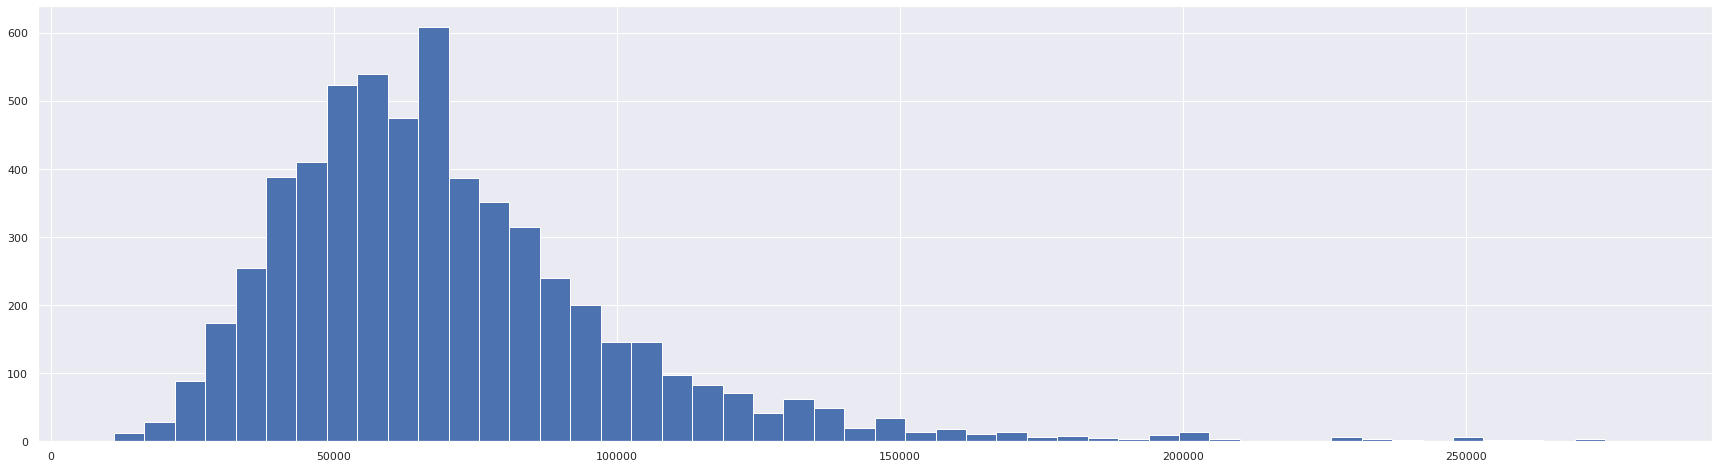

In [55]:
plt.figure(figsize=(30,8))
plt.hist(flats_euros['Цена'], bins=50)
plt.ticklabel_format(style='plain')
plt.show() 

## Енкодирање на вредности

In [56]:
all_onehotenc_flats = flats_euros.copy(deep=True)   # датасет каде сите вредности ќе ги енкодирам користејќи One-hot encoding
diffenc_flats = flats_euros.copy(deep=True)         # датасет каде различни вредности на атрибути ќе се енкодираан на различен начин, во зависност од вредностите

In [57]:
flats_euros.dtypes

Цена                      int64
Латитуда                float64
Лонгитуда               float64
Бројнасоби              float64
Квадратура                int64
Греење                   object
Спрат                    object
Типнастанот              object
Состојба                 object
Опрема                   object
Лифт                     object
Бројнабалкони            object
Бројнабањи               object
Подрум                   object
Бројнапаркинг/гаража     object
Ориентација              object
dtype: object

За енкодирање на вредностите ќе пробам два начина, со што ќе добијат два финални датасети кои ќе можат да се искористат за тренирање на моделите. Едниот датасет ќе се добие само со користење на one-hot encoding за сите атрибути кои се од категориски тип.

За другиот датасет ќе користам повеќе начина да ги енкодирам вредностите. За некои атрибути кои не се ординални, и кои секако имаат помалку од 15 unique вредности по атрибут, ќе користам one-hot encoding. За други вредности, кои имаат две вредности како “да/не“, едноставно ќе ги заменам вредностите со 1/0, 1 за вредноста која придонесува за повисока цена на станот. И за другите атрибути кои имаат ординални вредности, ќе користам ordinal-encoding.

Енкодирањето само со one-hot encoding ќе го направам на крајот на оваа секција, додека енкодирањето на секој атрибут посебно ќе го правам посебно, во секциите што следат за атрибутите поединечно.

### Ориентација

In [58]:
diffenc_flats.Ориентација.unique()

array(['Североисток', 'Југ', 'Исток', 'Југоисток', 'Запад', 'Север',
       'Југозапад', 'Северозапад'], dtype=object)

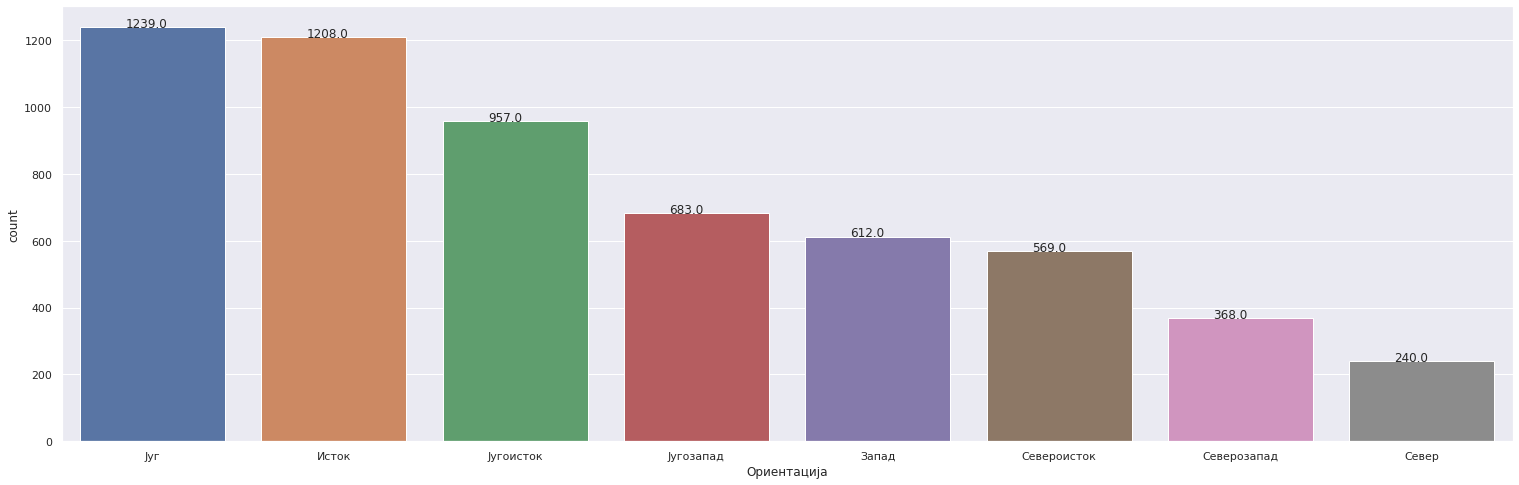

In [59]:
sns.set(rc={'figure.figsize':(26,8)})
ax = sns.countplot(x=diffenc_flats['Ориентација'],
                   order=diffenc_flats['Ориентација'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
   

Најголемиот дел од становите имаат оринетација кон исток и југ,а најмалку станови имаат ориентација кон северозапад и север. Бидејќи овие категориски вредности не се ординални, најдобро би било да искористиме One-hot encoding.
За оваа цел може да го искористиме и методот get_dummies() од pandas.

In [60]:
diffenc_flats = pd.get_dummies(flats_euros, prefix=['Ориен'], columns = ['Ориентација'])
diffenc_flats.head(3)

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,...,Подрум,Бројнапаркинг/гаража,Ориен_Југ,Ориен_Југозапад,Ориен_Југоисток,Ориен_Запад,Ориен_Исток,Ориен_Север,Ориен_Северозапад,Ориен_Североисток
0,127000,41.998834,21.395788,4.0,89,Централно,9кат,ВоЗграда,Нов,Наместен,...,Да,Гаража+2Паркингместа,0,0,0,0,0,0,0,1
1,95000,42.009423,20.971549,6.0,135,Друго,4кат,ВоЗграда,Реновиран,Наместен,...,Не,1Гаража,1,0,0,0,0,0,0,0
2,67500,41.987070,21.451929,2.0,45,Централно,6кат,ВоЗграда,Нов,Полунаместен,...,Не,1Паркинг,0,0,0,0,1,0,0,0


In [61]:
diffenc_flats.shape

(5876, 23)

### Број на паркинг/гаража

In [62]:
diffenc_flats['Бројнапаркинг/гаража'].unique()

array(['Гаража+2Паркингместа', '1Гаража', '1Паркинг', 'Нема',
       'Повеќеод3паркингместа', '2Паркингместа',
       'Гаража+Повеќеод3паркингместа', '3Паркингместа', 'Гаража+1Паркинг',
       'Гаража+3Паркингместа'], dtype=object)

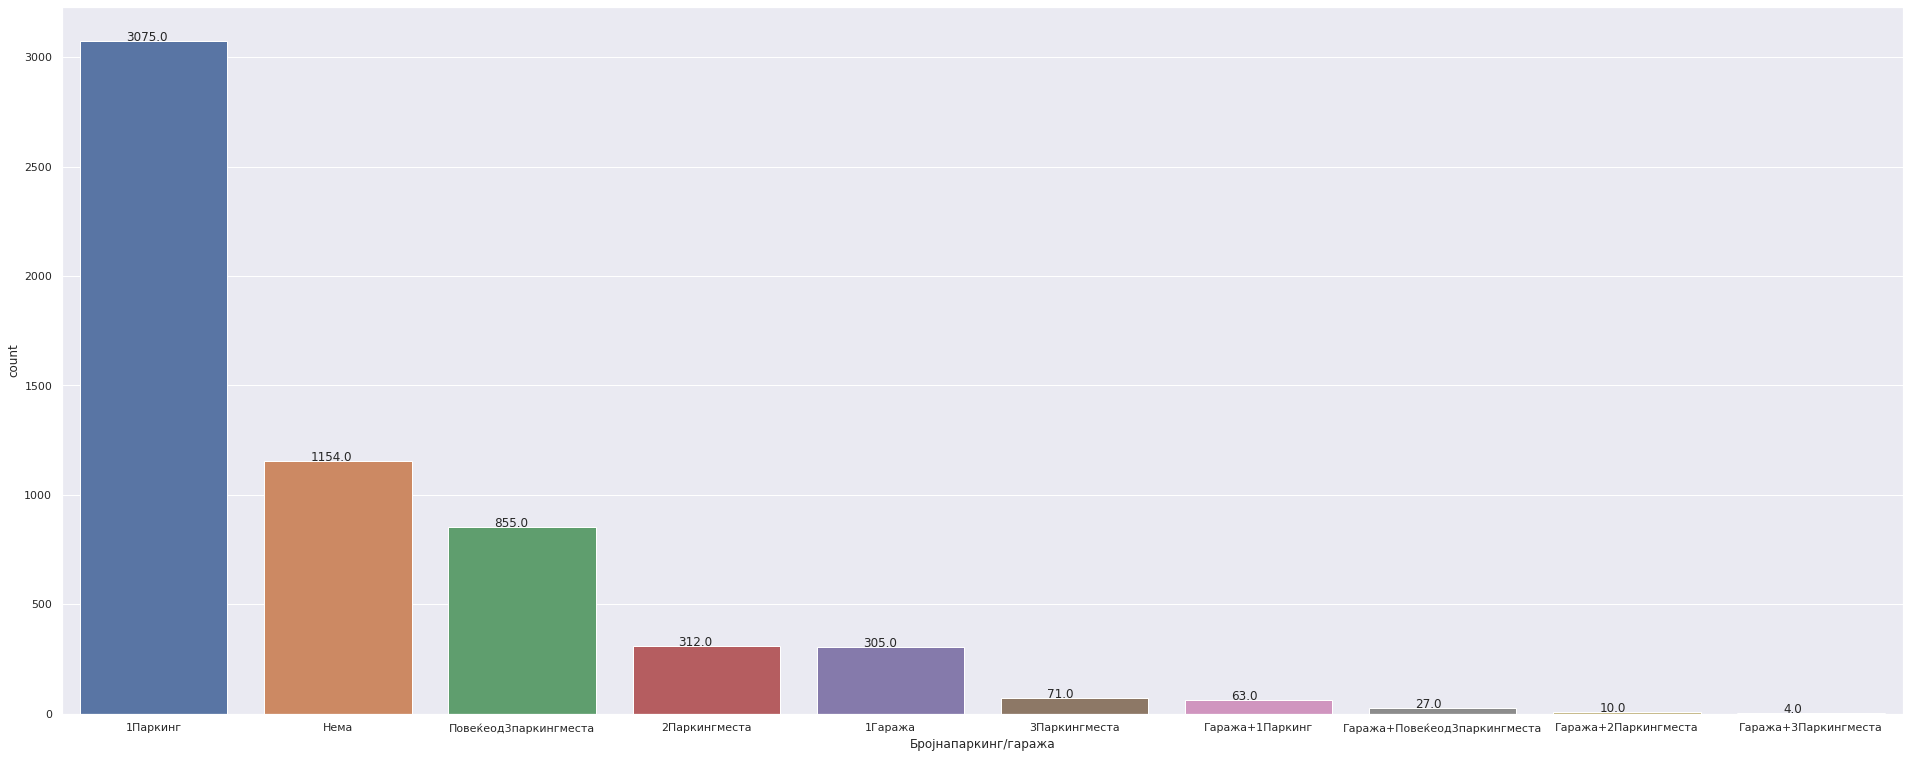

In [63]:
sns.set(rc={'figure.figsize':(33,13)})
ax = sns.countplot(x=diffenc_flats['Бројнапаркинг/гаража'],
                   order=diffenc_flats['Бројнапаркинг/гаража'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

И за ова ќе искористиме one-hot encoding со тоа што, таму каде што атрибутот е со вредност 'Нема' сите вредности од векторот ќе ги поставиме да се 0, за да не додаваме атрибут плус.

In [64]:
diffenc_flats["Бројнапаркинг/гаража"].replace({"Нема": "1aНема"}, inplace=True)

In [65]:
ohc = OneHotEncoder(drop='first', sparse=False)
ohe = ohc.fit_transform(diffenc_flats["Бројнапаркинг/гаража"].values.reshape(-1,1))

In [66]:
print(ohe.shape)
print(diffenc_flats.shape)

(5876, 9)
(5876, 23)


In [67]:
diffenc_flats.reset_index(drop=True)
diffenc_flats

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,...,Подрум,Бројнапаркинг/гаража,Ориен_Југ,Ориен_Југозапад,Ориен_Југоисток,Ориен_Запад,Ориен_Исток,Ориен_Север,Ориен_Северозапад,Ориен_Североисток
0,127000,41.998834,21.395788,4.0,89,Централно,9кат,ВоЗграда,Нов,Наместен,...,Да,Гаража+2Паркингместа,0,0,0,0,0,0,0,1
1,95000,42.009423,20.971549,6.0,135,Друго,4кат,ВоЗграда,Реновиран,Наместен,...,Не,1Гаража,1,0,0,0,0,0,0,0
2,67500,41.987070,21.451929,2.0,45,Централно,6кат,ВоЗграда,Нов,Полунаместен,...,Не,1Паркинг,0,0,0,0,1,0,0,0
3,95000,41.987628,21.447906,3.0,99,Струја,Приземје,ВоЗграда,Реновиран,Празен,...,Да,1Паркинг,0,0,0,0,1,0,0,0
4,52000,42.060063,21.450033,3.0,83,Струја,3кат,ВоЗграда,Реновиран,Наместен,...,Да,1aНема,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5871,42500,42.009423,20.971549,3.0,80,Струја,4кат,ВоЗграда,Стар,Празен,...,Да,1Паркинг,0,0,0,0,0,0,0,1
5872,21000,41.745515,22.193960,2.0,42,Дрва,2кат,ВоЗграда,Стар,Полунаместен,...,Да,1Паркинг,0,0,1,0,0,0,0,0
5873,21500,41.745515,22.193960,2.0,42,Дрва,2кат,ВоЗграда,Стар,Полунаместен,...,Да,1Паркинг,0,0,1,0,0,0,0,0
5874,34000,41.987070,21.451929,1.0,30,Централно,1кат,ВоЗграда,Реновиран,Наместен,...,Да,Повеќеод3паркингместа,0,0,0,0,0,1,0,0


In [68]:
dfOneHot = pd.DataFrame(ohe, columns = [str(ohc.categories_[0][i]) for i in range(1,len(ohc.categories_[0]))])
diffenc_flats = pd.concat([diffenc_flats, dfOneHot], axis=1)

In [69]:
diffenc_flats.drop('Бројнапаркинг/гаража', inplace=True, axis=1)

In [70]:
diffenc_flats.shape

(5876, 31)

### Подрум

In [71]:
diffenc_flats['Подрум'].unique()

array(['Да', 'Не'], dtype=object)

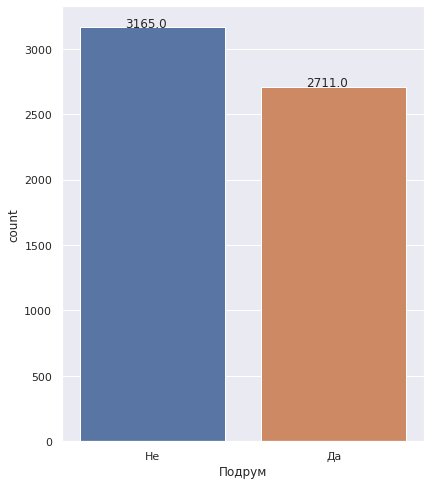

In [72]:
sns.set(rc={'figure.figsize':(6.5,8)})
ax = sns.countplot(x=diffenc_flats['Подрум'],
                   order=diffenc_flats['Подрум'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

Бидејќи вредностите Да и Не треба да се енкодираат, а доколку одреден стан разполага со подрум цената, нормално е да е поскапа, вредноста Да ќе ја замениме со 1, а вредноста Не со 0.

In [73]:
diffenc_flats["Подрум"].replace({"Да": "1", "Не": "0"}, inplace=True) 
diffenc_flats['Подрум']= diffenc_flats['Подрум'].astype('int64')

### Број на бањи

In [74]:
diffenc_flats['Бројнабањи'].unique()

array(['2', '1', 'Повеќеод2'], dtype=object)

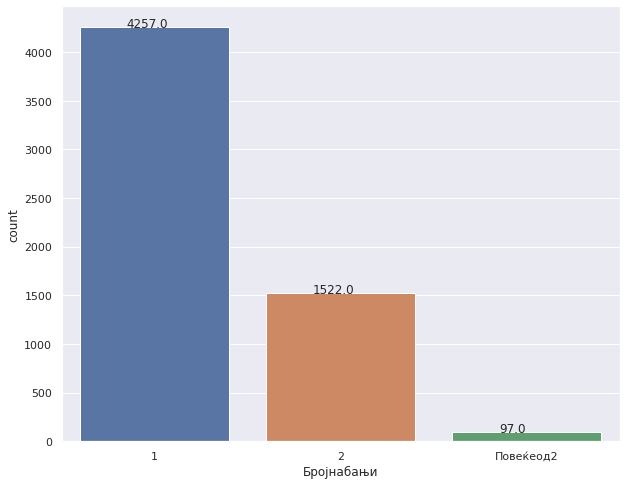

In [75]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.countplot(x=diffenc_flats['Бројнабањи'],
                   order=diffenc_flats['Бројнабањи'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

264 од сите податоци имаат повеќе од 2 бањи во станот. За енкодирање, за вредноста 'повеќеод2' ќе замениме вредност 3, бидејќи дури и да има во некои станови повеќе од 3 бањи, тоа е многу ретко.

In [76]:
diffenc_flats["Бројнабањи"].replace({"Повеќеод2": "3"}, inplace=True)
diffenc_flats['Бројнабањи']= diffenc_flats['Бројнабањи'].astype('int64') 

### Број на балкони

In [77]:
diffenc_flats['Бројнабалкони'].unique()

array(['1Балкон', '1Тераса', 'Тераса+1Балкон', '2Балкони', 'Нема',
       '3Балкони', 'Тераса+Повеќеод3балкони', 'Тераса+3Балкони',
       'Тераса+2Балкони', 'Повеќеод3балкони'], dtype=object)

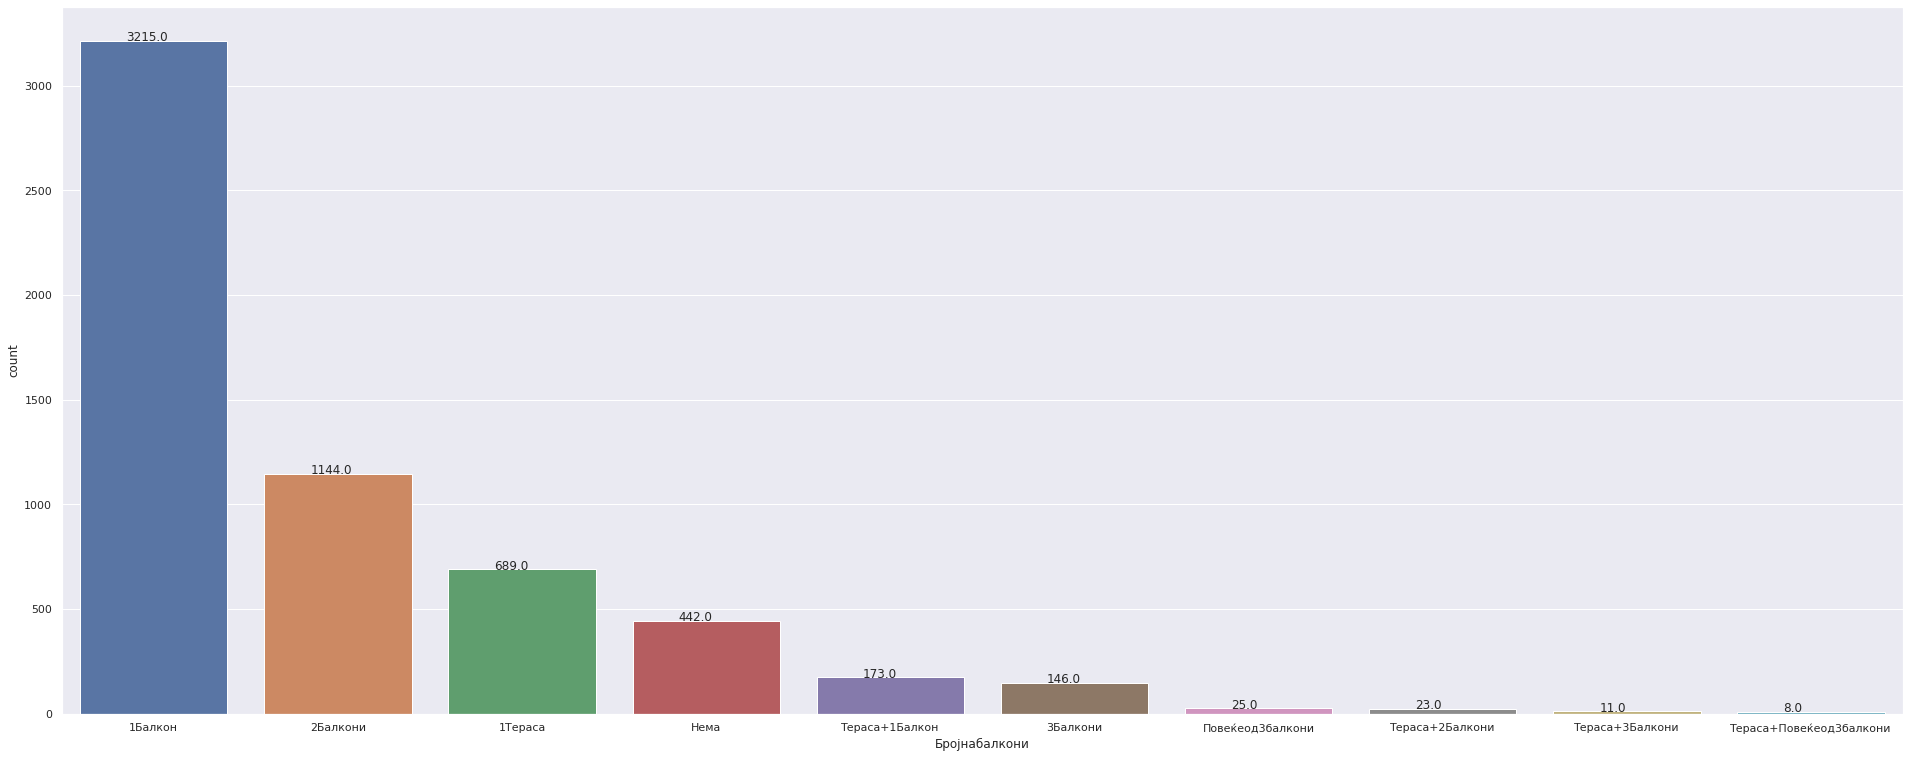

In [78]:
sns.set(rc={'figure.figsize':(33,13)})
ax = sns.countplot(x=diffenc_flats['Бројнабалкони'],
                   order=diffenc_flats['Бројнабалкони'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

И за овој атрибут ќе користам one-hot encoding бидејќи вредностите немаат јасна ординалност каде што ќе може да кажеме колкава е разликата од една вредност до друга. Но како што може да видиме на бар графикот погоре, со вредностите 'Тераса+Повеќеод3балкони' има само 24 инстанци, а со 'Тераса+3Балкони' има само 14 инстанци. Па за да не се зголемува залудно бројот на атрибути кога ќе направиме one-hot encoding, овие две вредноти ќе ги заменам со вредноста 'Повеќеод3балкони'.

In [79]:
diffenc_flats["Бројнабалкони"].replace({"Тераса+Повеќеод3балкони": "Повеќеод3балкони"}, inplace=True)
diffenc_flats["Бројнабалкони"].replace({"Тераса+3Балкони": "Повеќеод3балкони"}, inplace=True)

In [80]:
diffenc_flats["Бројнабалкони"].replace({"Нема": "1aНема"}, inplace=True)

In [81]:
ohc = OneHotEncoder(drop='first', sparse=False)
ohe = ohc.fit_transform(diffenc_flats["Бројнабалкони"].values.reshape(-1,1))

In [82]:
dfOneHot = pd.DataFrame(ohe, columns = [str(ohc.categories_[0][i]) for i in range(1,len(ohc.categories_[0]))])
diffenc_flats = pd.concat([diffenc_flats, dfOneHot], axis=1)

In [83]:
diffenc_flats.drop('Бројнабалкони', inplace=True, axis=1)

### Лифт

In [84]:
diffenc_flats['Лифт'].unique()

array(['Да', 'Не'], dtype=object)

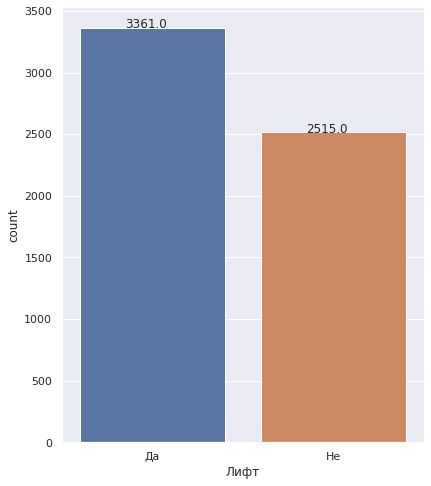

In [85]:
sns.set(rc={'figure.figsize':(6.5,8)})
ax = sns.countplot(x=diffenc_flats['Лифт'],
                   order=diffenc_flats['Лифт'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

In [86]:
diffenc_flats["Лифт"].replace({"Да": "1", "Не": "0"}, inplace=True) 
diffenc_flats['Лифт']= diffenc_flats['Лифт'].astype('int64')

### Опрема

In [87]:
diffenc_flats['Опрема'].unique()

array(['Наместен', 'Полунаместен', 'Празен', 'Луксузен'], dtype=object)

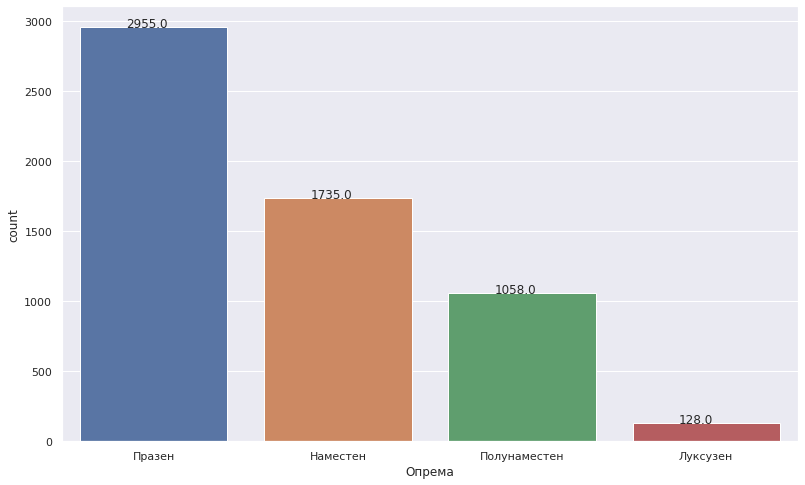

In [88]:
sns.set(rc={'figure.figsize':(13.2,8)})
ax = sns.countplot(x=diffenc_flats['Опрема'],
                   order=diffenc_flats['Опрема'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

За овој атрибут ќе искористам ќе искористам OrdinalEncoder затоа што цените на становите се зголемуваат според тоа како е опремен станот, празен<полунаместен<наместен<луксузен. 

In [89]:
oprema_dict = { 'Празен' : 1, 'Полунаместен':2, 'Наместен':3, 'Луксузен':4}
diffenc_flats['Опрема'] = diffenc_flats.Опрема.map(oprema_dict)

In [90]:
diffenc_flats['Опрема']= diffenc_flats['Опрема'].astype('int64')

### Состојба

In [91]:
diffenc_flats['Состојба'].unique()

array(['Нов', 'Реновиран', 'Стар', 'Воградба'], dtype=object)

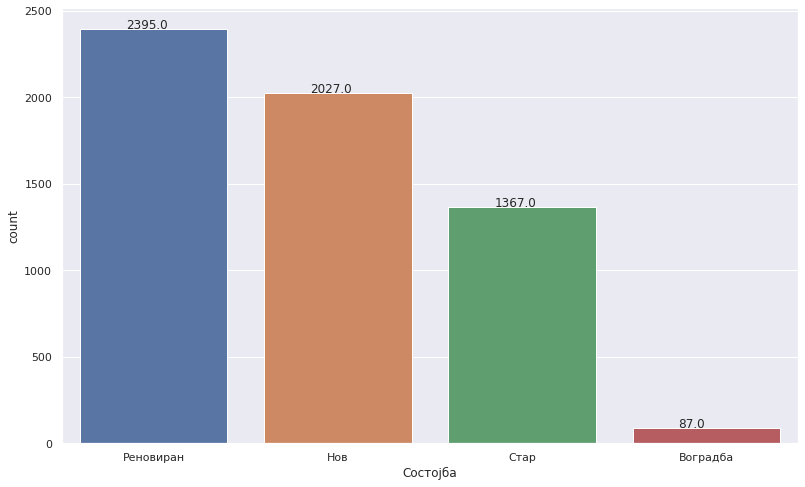

In [92]:
sns.set(rc={'figure.figsize':(13.2,8)})
ax = sns.countplot(x=diffenc_flats['Состојба'],
                   order=diffenc_flats['Состојба'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

Поради истите причина како и за атрибутот 'Опрема', и овде ќе користам OrdinalEncoder.

In [93]:
sostojba_dict = { 'Воградба' : 1, 'Стар':2, 'Реновиран':3, 'Нов':4}
diffenc_flats['Состојба'] = diffenc_flats.Состојба.map(sostojba_dict)

In [94]:
diffenc_flats['Состојба']= diffenc_flats['Состојба'].astype('int64')

In [95]:
diffenc_flats.head()

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Спрат,Типнастанот,Состојба,Опрема,...,Гаража+3Паркингместа,Гаража+Повеќеод3паркингместа,Повеќеод3паркингместа,1Балкон,1Тераса,2Балкони,3Балкони,Повеќеод3балкони,Тераса+1Балкон,Тераса+2Балкони
0,127000,41.998834,21.395788,4.0,89,Централно,9кат,ВоЗграда,4,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,95000,42.009423,20.971549,6.0,135,Друго,4кат,ВоЗграда,3,3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,67500,41.987070,21.451929,2.0,45,Централно,6кат,ВоЗграда,4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,95000,41.987628,21.447906,3.0,99,Струја,Приземје,ВоЗграда,3,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,52000,42.060063,21.450033,3.0,83,Струја,3кат,ВоЗграда,3,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Тип на станот

In [96]:
diffenc_flats['Типнастанот'].unique()

array(['ВоЗграда', 'Вокуќа'], dtype=object)

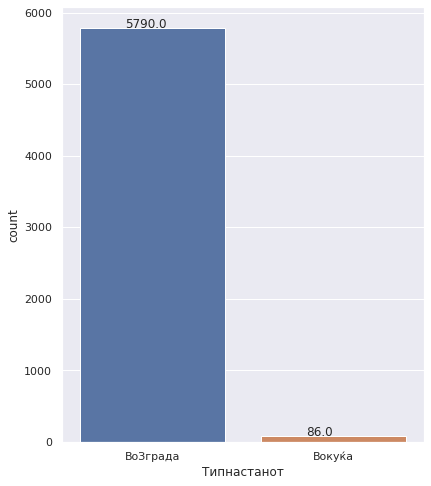

In [97]:
sns.set(rc={'figure.figsize':(6.5,8)})
ax = sns.countplot(x=diffenc_flats['Типнастанот'],
                   order=diffenc_flats['Типнастанот'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

In [98]:
diffenc_flats["Типнастанот"].replace({"ВоЗграда": "1", "Вокуќа": "2"}, inplace=True) 
diffenc_flats['Типнастанот']= diffenc_flats['Типнастанот'].astype('int64')

### Спрат

In [99]:
diffenc_flats['Спрат'].unique()

array(['9кат', '4кат', '6кат', 'Приземје', '3кат', '5кат', '2кат', '1кат',
       '12кат', '>15кат', '7кат', '8кат', '11кат', '10кат', 'Поткровје',
       '14кат', 'Сутеренстан', '13кат'], dtype=object)

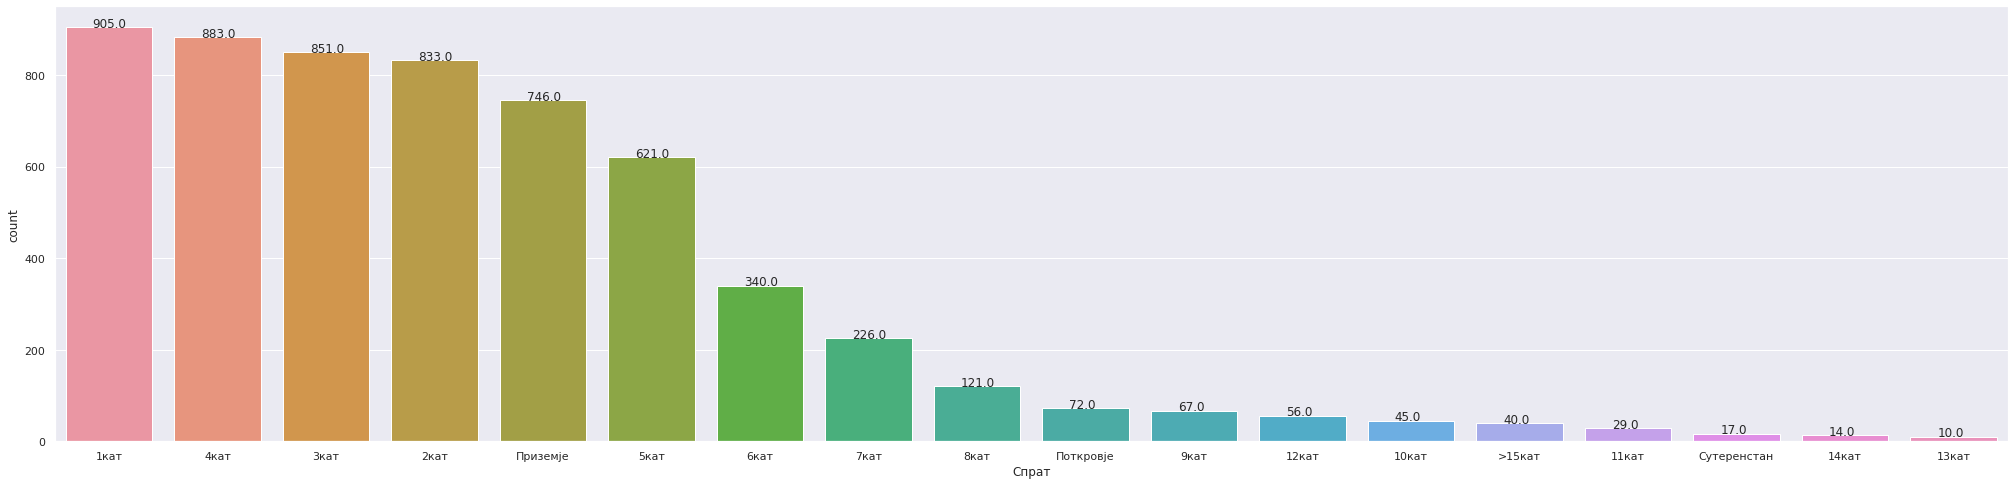

In [100]:
sns.set(rc={'figure.figsize':(35,8)})
ax = sns.countplot(x=diffenc_flats['Спрат'],
                   order=diffenc_flats['Спрат'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

Бидејќи има се помалку станови кои се наоѓаат на кат погоре од 10ти, сите вредности над 10ти и 10ти кат ќе ги ставам во еден аргумент >=10кат. Овие вредности иако изгледаат ординални, не може однапред да знаеме како влијаат на цената, па затоа ќе ги енкодирам со one-hot encoding.

In [101]:
diffenc_flats["Спрат"].replace({"10кат": ">=10кат", "11кат" : ">=10кат", "12кат" : ">=10кат", "13кат" : ">=10кат", "14кат" : ">=10кат", ">15кат" : ">=10кат", "Сутеренстан" : "1аСутерен"}, inplace=True)

In [102]:
ohc = OneHotEncoder(drop='first', sparse=False)
ohe = ohc.fit_transform(diffenc_flats["Спрат"].values.reshape(-1,1))

In [103]:
dfOneHot = pd.DataFrame(ohe, columns = [str(ohc.categories_[0][i]) for i in range(1,len(ohc.categories_[0]))])
diffenc_flats = pd.concat([diffenc_flats, dfOneHot], axis=1)

In [104]:
diffenc_flats.drop('Спрат', inplace=True, axis=1)

In [105]:
pd.set_option('max_columns', None)
diffenc_flats.head()

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење,Типнастанот,Состојба,Опрема,Лифт,Бројнабањи,Подрум,Ориен_Југ,Ориен_Југозапад,Ориен_Југоисток,Ориен_Запад,Ориен_Исток,Ориен_Север,Ориен_Северозапад,Ориен_Североисток,1Гаража,1Паркинг,2Паркингместа,3Паркингместа,Гаража+1Паркинг,Гаража+2Паркингместа,Гаража+3Паркингместа,Гаража+Повеќеод3паркингместа,Повеќеод3паркингместа,1Балкон,1Тераса,2Балкони,3Балкони,Повеќеод3балкони,Тераса+1Балкон,Тераса+2Балкони,1кат,2кат,3кат,4кат,5кат,6кат,7кат,8кат,9кат,>=10кат,Поткровје,Приземје
0,127000,41.998834,21.395788,4.0,89,Централно,1,4,3,1,2,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,95000,42.009423,20.971549,6.0,135,Друго,1,3,3,0,2,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67500,41.987070,21.451929,2.0,45,Централно,1,4,2,1,1,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,95000,41.987628,21.447906,3.0,99,Струја,1,3,1,1,1,1,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,52000,42.060063,21.450033,3.0,83,Струја,1,3,3,0,2,1,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Греење

In [106]:
flats['Греење'].unique()

array(['Централно', 'Друго', 'Струја', 'Нема', 'Дрва', 'Соларнаенергија'],
      dtype=object)

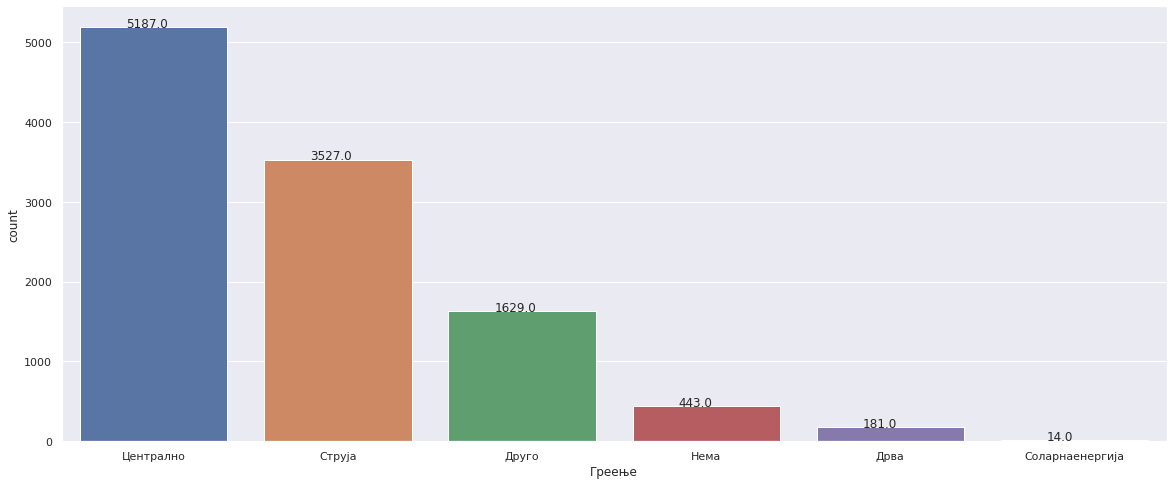

In [107]:
sns.set(rc={'figure.figsize':(19.8,8)})
ax = sns.countplot(x=flats['Греење'],
                   order=flats['Греење'].value_counts(ascending=False).index);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01)) 

И овде ќе искористам one-hot encoding со што греењето со соларна енергија ќе го спојам со Друго, бидејќи има само 15 инстанци со вредност Цоларнаенергија за атрибутот Греење.



In [108]:
diffenc_flats["Греење"].replace({"Соларнаенергија": "Друго", "Нема": "1Нема"}, inplace=True)

In [109]:
ohc = OneHotEncoder(drop='first', sparse=False)
ohe = ohc.fit_transform(diffenc_flats["Греење"].values.reshape(-1,1))

In [110]:
dfOneHot = pd.DataFrame(ohe, columns = [str(ohc.categories_[0][i]) for i in range(1,len(ohc.categories_[0]))])
diffenc_flats = pd.concat([diffenc_flats, dfOneHot], axis=1)

In [111]:
diffenc_flats.drop('Греење', inplace=True, axis=1)

In [112]:
diffenc_flats.rename(columns={"Типнастанот":"ВоКуќа/ВоЗграда", "Дрва":"ГреењеДрва", "Друго":"ГреењеДруго", "Струја":"ГреењеСтруја", "Централно":"ГреењеЦентрално"}, inplace=True)

In [113]:
diffenc_flats.head()

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,ВоКуќа/ВоЗграда,Состојба,Опрема,Лифт,Бројнабањи,Подрум,Ориен_Југ,Ориен_Југозапад,Ориен_Југоисток,Ориен_Запад,Ориен_Исток,Ориен_Север,Ориен_Северозапад,Ориен_Североисток,1Гаража,1Паркинг,2Паркингместа,3Паркингместа,Гаража+1Паркинг,Гаража+2Паркингместа,Гаража+3Паркингместа,Гаража+Повеќеод3паркингместа,Повеќеод3паркингместа,1Балкон,1Тераса,2Балкони,3Балкони,Повеќеод3балкони,Тераса+1Балкон,Тераса+2Балкони,1кат,2кат,3кат,4кат,5кат,6кат,7кат,8кат,9кат,>=10кат,Поткровје,Приземје,ГреењеДрва,ГреењеДруго,ГреењеСтруја,ГреењеЦентрално
0,127000,41.998834,21.395788,4.0,89,1,4,3,1,2,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,95000,42.009423,20.971549,6.0,135,1,3,3,0,2,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,67500,41.987070,21.451929,2.0,45,1,4,2,1,1,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,95000,41.987628,21.447906,3.0,99,1,3,1,1,1,1,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,52000,42.060063,21.450033,3.0,83,1,3,3,0,2,1,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Пробни модели 

### Модел со податоците енкодирани со различни техники за различни колони

In [114]:
y = diffenc_flats['Цена']
x = diffenc_flats.loc[:, diffenc_flats.columns != 'Цена']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [116]:
model = XGBRegressor(objective ='reg:squarederror',
    colsample_bytree = 0.3, learning_rate = 0.1,
    max_depth = 5, alpha = 2, n_estimators = 10)


model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))


Mean Absolute Error : 159.0541624700154
Mean Absolute Percentage error: 0.31866260996517104
R2_score:-5.007017306521969


### Модел со податоците енкодирани само со one-hot encoding

In [118]:
onehotenc_flats = pd.get_dummies(all_onehotenc_flats, columns = ['Греење',
       'Спрат', 'Типнастанот', 'Состојба', 'Опрема', 'Лифт', 'Бројнабалкони',
       'Бројнабањи', 'Подрум', 'Бројнапаркинг/гаража', 'Ориентација'], drop_first='false')
onehotenc_flats.shape

(5876, 63)

In [119]:
y = onehotenc_flats['Цена']
x = onehotenc_flats.loc[:, onehotenc_flats.columns != 'Цена']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [120]:
model = XGBRegressor(objective ='reg:squarederror',
    colsample_bytree = 0.3, learning_rate = 0.1,
    max_depth = 5, alpha = 2, n_estimators = 10)


model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))


Mean Absolute Error : 159.25370494256373
Mean Absolute Percentage error: 0.31557481837865964
R2_score:-5.971509987673672


# Зачувување на податоците во .csv датотеки

In [129]:
flats_euros.to_csv('/content/drive/MyDrive/Colab Notebooks/TimskiProekt/flats_in_euros_without_outliers.csv')

In [123]:
test_flats.to_csv('/content/drive/MyDrive/Colab Notebooks/TimskiProekt/test_flats.csv')

In [125]:
diffenc_flats.to_csv('/content/drive/MyDrive/Colab Notebooks/TimskiProekt/defferenct_encoding_flats.csv')

In [126]:
onehotenc_flats.to_csv('/content/drive/MyDrive/Colab Notebooks/TimskiProekt/allOneHot_encoding_flats.csv')